## Cutout and Encoding Pipeline

In [1]:
#install essential packages
!pip install wandb torch torchvision

  Using cached wandb-0.22.1-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached sentry_sdk-2.39.0-py2.py3-none-any.whl.metadata (10 kB)
Using cached wandb-0.22.1-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.6 MB)
Using cached sentry_sdk-2.39.0-py2.py3-none-any.whl (370 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [wandb]32m1/2 [wandb]


## A. Cutout Pipeline

In [2]:
import os
import json
from PIL import Image, ImageDraw
import numpy as np
from tqdm.notebook import tqdm

In [3]:
try:
    from pycocotools import mask as maskUtils
    HAS_PYCOCO = True
except Exception:
    HAS_PYCOCO = False

In [4]:
def polygons_to_mask(segmentation, height, width):
    mask_img = Image.new('L', (width, height), 0)
    draw = ImageDraw.Draw(mask_img)
    polys = segmentation if (len(segmentation) and isinstance(segmentation[0], list)) else [segmentation]
    for poly in polys:
        pts = [(float(poly[i]), float(poly[i+1])) for i in range(0, len(poly), 2)]
        draw.polygon(pts, outline=1, fill=1)
    return np.array(mask_img, dtype=np.uint8) * 255

In [5]:
def rle_to_mask(rle, height, width):
    if not HAS_PYCOCO:
        raise RuntimeError("pycocotools required for RLE masks. Install with `pip install pycocotools`.")
    m = maskUtils.decode(rle)
    if m.ndim == 3:
        m = np.any(m, axis=2).astype(np.uint8)
    return (m * 255).astype(np.uint8)

In [6]:
def save_mask_png(mask_arr, out_path):
    Image.fromarray(mask_arr).save(out_path)

In [7]:
def save_masked_rgba(image_path, mask_arr, out_path, bbox=None, crop=True):
    img = Image.open(image_path).convert("RGBA")
    mask_img = Image.fromarray(mask_arr).convert("L")
    img.putalpha(mask_img)
    if crop and bbox is not None:
        x, y, w, h = [int(v) for v in bbox]
        out = img.crop((x, y, x + w, y + h))
    else:
        out = img
    out.save(out_path)

In [18]:
# === CONFIGURATION ===
ann_file   = "./Some-Trees-Dataset-11/train/_annotations.coco.json"
images_dir = "./Some-Trees-Dataset-11/test"
out_dir    = "./Some-Trees-Dataset-11/exported_masks"
save_rgba_crops = True   # toggle on/off

In [19]:
# === EXECUTION ===
with open(ann_file, 'r') as f:
    coco = json.load(f)

In [20]:
images = {img['id']: img for img in coco.get('images', [])}
os.makedirs(out_dir, exist_ok=True)
masks_dir = os.path.join(out_dir, "masks")
os.makedirs(masks_dir, exist_ok=True)
if save_rgba_crops:
    crops_dir = os.path.join(out_dir, "masked_crops")
    os.makedirs(crops_dir, exist_ok=True)

In [21]:
for ann in tqdm(coco.get('annotations', []), desc="Exporting masks"):
    img_id = ann['image_id']
    img_info = images.get(img_id)
    if img_info is None:
        continue

    width, height = img_info['width'], img_info['height']
    seg = ann.get('segmentation')

    try:
        if isinstance(seg, dict) and 'counts' in seg:
            mask = rle_to_mask(seg, height, width)
        else:
            mask = polygons_to_mask(seg, height, width)
    except Exception as e:
        print(f"Skipping ann {ann.get('id')} ({e})")
        continue

    base = os.path.splitext(os.path.basename(img_info['file_name']))[0]
    mask_name = f"{base}_ann{ann.get('id')}_cat{ann.get('category_id')}.png"
    mask_path = os.path.join(masks_dir, mask_name)
    save_mask_png(mask, mask_path)

    if save_rgba_crops:
        image_path = os.path.join(images_dir, img_info['file_name'])
        if os.path.exists(image_path):
            bbox = ann.get('bbox')
            crop_name = f"{base}_ann{ann.get('id')}_cat{ann.get('category_id')}_crop.png"
            crop_path = os.path.join(crops_dir, crop_name)
            save_masked_rgba(image_path, mask, crop_path, bbox=bbox, crop=True)

print('done.')

Exporting masks:   0%|          | 0/4274 [00:00<?, ?it/s]

done.


## B. Autoencoder Pipeline

In [2]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import wandb
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision

In [3]:
wandb.init(project="intreeligent_autoencoder_test", name="autoencoder_train")
config = wandb.config
config.lr = 1e-3
config.epochs= 30
config.batch_size = 32
config.latent_dim = 64

wandb: Currently logged in as: juanico-hernel064 (juanico-hernel064-university-of-science-and-technology-o) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [15]:
class MaskDataset(Dataset):
    def __init__(self, files, size=128, background="black"):
        """
        Args:
            files: list of image paths
            size: resize target (square)
            background: 'black' or 'white' background fill
        """
        self.files = files
        self.size = size
        self.bg_color = (0,0,0) if background=="black" else (255,255,255)
        self.transform = transforms.Compose([
            transforms.Resize((size, size), interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert("RGBA")

        # split into RGB and Alpha
        r,g,b,a = img.split()

        # apply alpha as mask: paste object on background
        rgb_img = Image.merge("RGB", (r,g,b))
        bg = Image.new("RGB", img.size, self.bg_color)
        masked = Image.composite(rgb_img, bg, a)  # keep only object

        # resize + tensor
        masked = self.transform(masked)   # shape: (3, size, size)
        return masked, str(path)


In [16]:
from pathlib import Path
import torch

# paths
DATA_DIR = Path("./Some-Trees-Dataset-11/exported_masks/masked_crops")   # your cropped masks
OUT_DIR  = Path("./runs")                          # where to save checkpoints & latents
OUT_DIR.mkdir(parents=True, exist_ok=True)

# training & model
IMG_SIZE    = 512          # recommended; 64 or 128 are common choices
BATCH_SIZE  = 8
LATENT_DIM  = 256          # try 32/64/128
LR          = 1e-3
EPOCHS      = 30
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# logging
USE_WANDB   = True       # set True if you want wandb monitoring (account required)

In [17]:
# gather pngs and split train/val
from sklearn.model_selection import train_test_split
files = sorted([p for p in DATA_DIR.glob("*.png")])
train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

train_ds = MaskDataset(train_files, size=IMG_SIZE)
val_ds   = MaskDataset(val_files,   size=IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

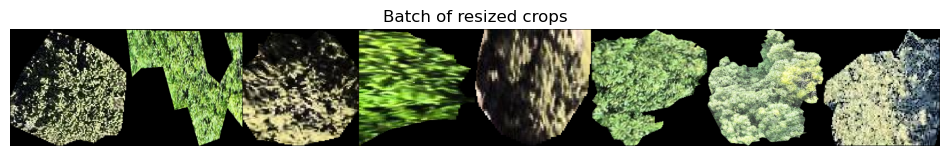

In [18]:
imgs, paths = next(iter(train_loader))  # one batch
grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True)

plt.figure(figsize=(12,6))
plt.imshow(grid.permute(1,2,0))  # CHW -> HWC
plt.axis("off")
plt.title("Batch of resized crops")
plt.show()

Shape: torch.Size([3, 512, 512])


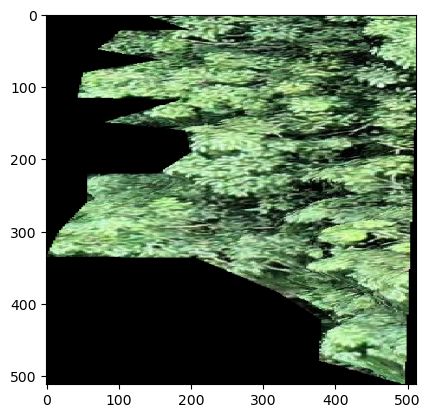

In [19]:
#Looking at a sample
img_tensor, path = train_ds[20]
print("Shape:", img_tensor.shape)  # (3, 64, 64)

img_np = img_tensor.permute(1,2,0).numpy()  # CHW -> HWC
plt.imshow(img_np)
plt.axis("on")
plt.show()

### Class for the convolutions

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 3,
                               stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class ConvAutoencoder512(nn.Module):
    def __init__(self, latent_dim=128, in_channels=3):
        super().__init__()

        # === Encoder ===
        self.encoder_conv = nn.Sequential(
            ConvBlock(in_channels, 32),  # 512 -> 256
            ConvBlock(32, 64),           # 256 -> 128
            ConvBlock(64, 128),          # 128 -> 64
        )

        # Bottleneck
        self.gap = nn.AdaptiveAvgPool2d((1,1))  # (128,64,64) -> (128,1,1)
        self.fc_mu   = nn.Linear(128, latent_dim)
        self.fc_dec  = nn.Linear(latent_dim, 128*64*64)  # must be 524,288!

        # === Decoder ===
        self.decoder = nn.Sequential(
            DeconvBlock(128, 64),                 # 64 -> 128
            DeconvBlock(64, 32),                  # 128 -> 256
            nn.ConvTranspose2d(32, in_channels, 3,
                               stride=2, padding=1, output_padding=1), # 256 -> 512
            nn.Sigmoid()
        )

    def forward(self, x):
        f = self.encoder_conv(x)
        pooled = self.gap(f).view(f.size(0), -1)
        z = self.fc_mu(pooled)

        f2 = self.fc_dec(z)
        print(">>> fc_dec output shape:", f2.shape)  # add this

        f2 = f2.view(-1, 128, 64, 64)   # this is where it fails
        out = self.decoder(f2)
        return out


    def encode(self, x):
        f = self.encoder_conv(x)
        pooled = self.gap(f).view(f.size(0), -1)
        z = self.fc_mu(pooled)
        return z



In [10]:
model = ConvAutoencoder512(latent_dim=128, in_channels=3).to(DEVICE)
print(model)

ConvAutoencoder512(
  (encoder_conv): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc_mu): Linear(in_features=128, out_features=128, bias=True)
  (fc_dec): Linear(in_features=128, out

In [11]:
import torch.nn as nn
criterion = nn.MSELoss()

In [12]:
# Grab a small batch
imgs, _ = next(iter(train_loader))
imgs = imgs.to(DEVICE)

# Forward pass
with torch.no_grad():
    outs = model(imgs)

print("input shape:", imgs.shape)
print("output shape:", outs.shape)
print("MSE sample:", criterion(outs, imgs).item())

>>> fc_dec output shape: torch.Size([8, 524288])
input shape: torch.Size([8, 3, 512, 512])
output shape: torch.Size([8, 3, 512, 512])
MSE sample: 0.15106570720672607


In [13]:
#Micro-run
import torch.optim as optim

mini_loader = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)

model = ConvAutoencoder512(latent_dim=LATENT_DIM, in_channels=3).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for step, (imgs, _) in enumerate(mini_loader):
    imgs = imgs.to(DEVICE)
    optimizer.zero_grad()
    outs = model(imgs)
    loss = criterion(outs, imgs)
    loss.backward()
    optimizer.step()
    print(f"Step {step}, Loss: {loss.item():.6f}")
    if step > 20: break

>>> fc_dec output shape: torch.Size([4, 524288])
Step 0, Loss: 0.141786
>>> fc_dec output shape: torch.Size([4, 524288])
Step 1, Loss: 0.131645
>>> fc_dec output shape: torch.Size([4, 524288])
Step 2, Loss: 0.125730
>>> fc_dec output shape: torch.Size([4, 524288])
Step 3, Loss: 0.117177
>>> fc_dec output shape: torch.Size([4, 524288])
Step 4, Loss: 0.125359
>>> fc_dec output shape: torch.Size([4, 524288])
Step 5, Loss: 0.120197
>>> fc_dec output shape: torch.Size([4, 524288])
Step 6, Loss: 0.097292
>>> fc_dec output shape: torch.Size([4, 524288])
Step 7, Loss: 0.103278
>>> fc_dec output shape: torch.Size([4, 524288])
Step 8, Loss: 0.096445
>>> fc_dec output shape: torch.Size([4, 524288])
Step 9, Loss: 0.101973
>>> fc_dec output shape: torch.Size([4, 524288])
Step 10, Loss: 0.095890
>>> fc_dec output shape: torch.Size([4, 524288])
Step 11, Loss: 0.100868
>>> fc_dec output shape: torch.Size([4, 524288])
Step 12, Loss: 0.091626
>>> fc_dec output shape: torch.Size([4, 524288])
Step 13, Los

Train Epoch 1/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 2/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 3/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 4/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 5/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

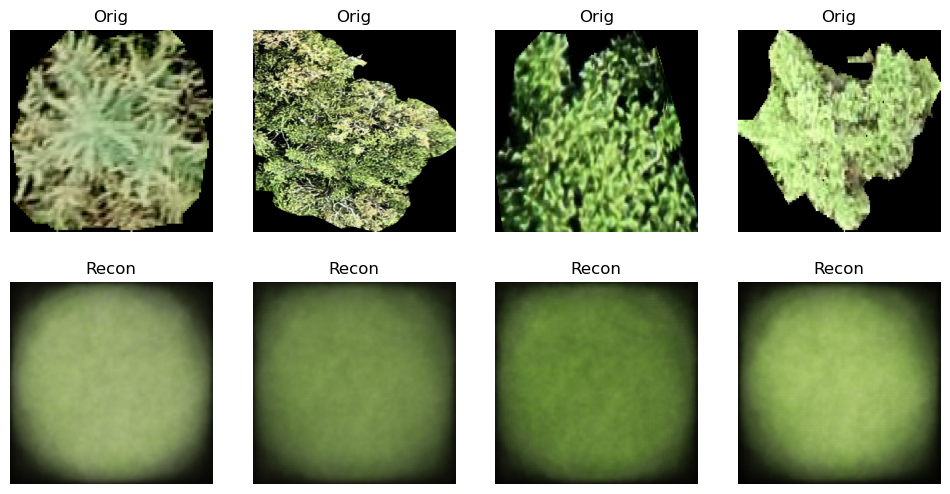

Train Epoch 6/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 7/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 8/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 9/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 10/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

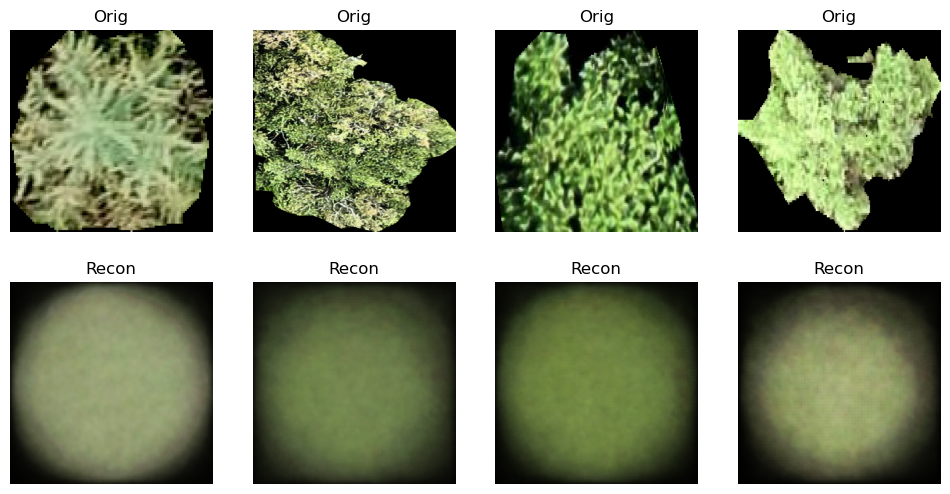

Train Epoch 11/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 12/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 13/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 14/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 15/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

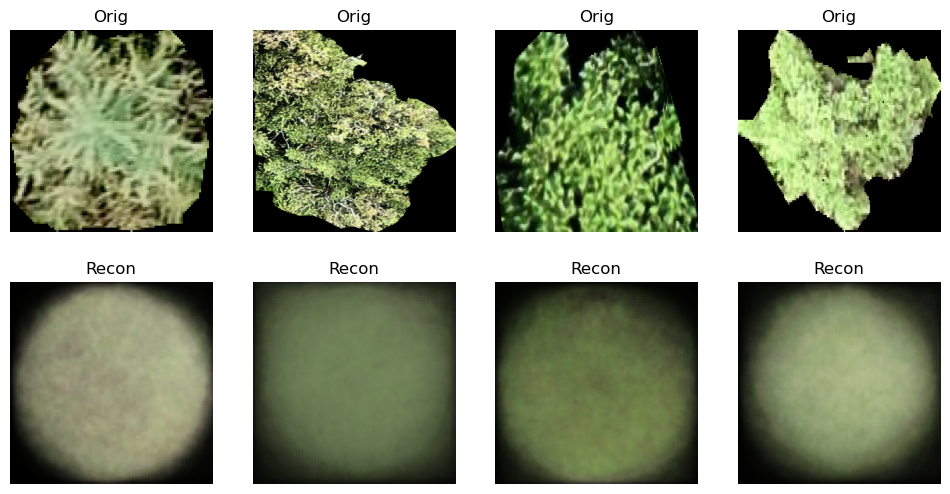

Train Epoch 16/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 17/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 18/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 19/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 20/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

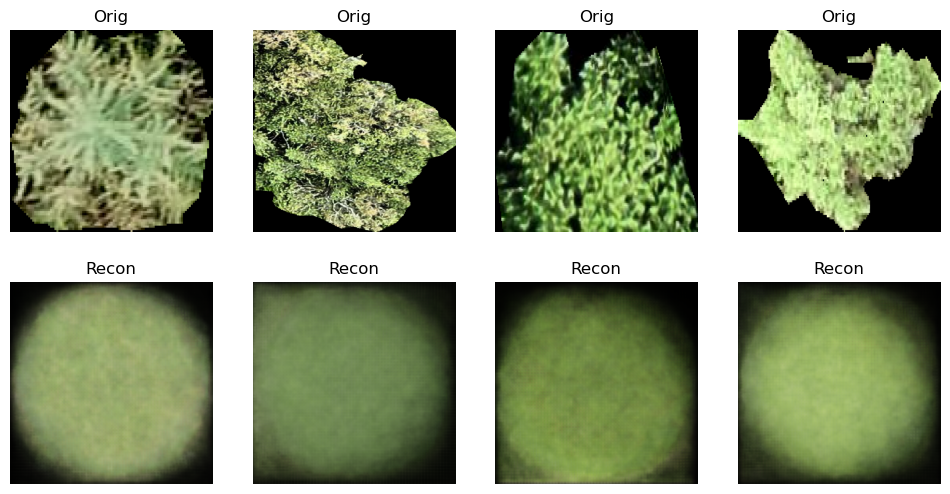

Train Epoch 21/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 22/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 23/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 24/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 25/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

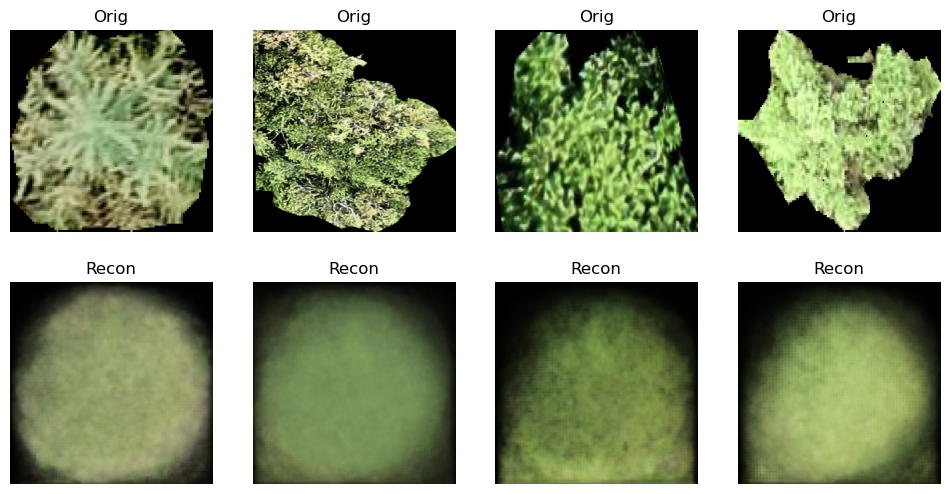

Train Epoch 26/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 27/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 28/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 29/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

Train Epoch 30/30:   0%|          | 0/428 [00:00<?, ?it/s]

>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output shape: torch.Size([8, 524288])
>>> fc_dec output sh

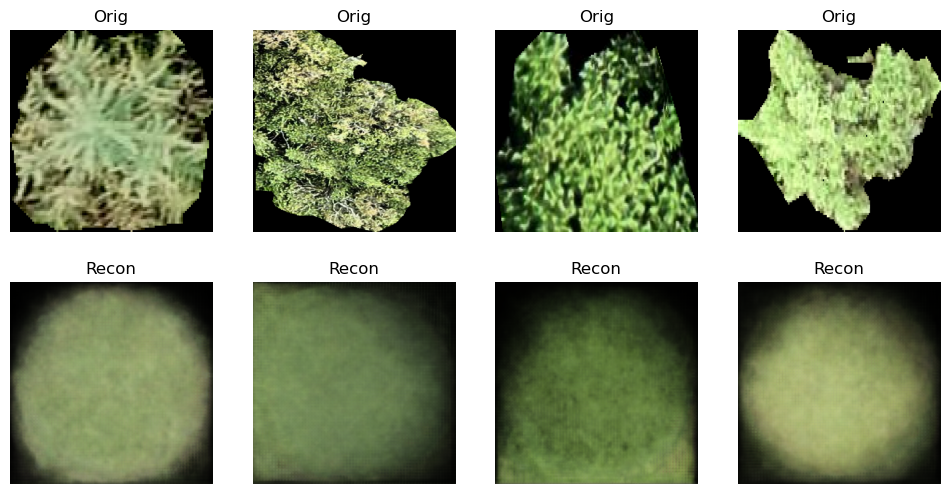

In [19]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# === Model ===
model = ConvAutoencoder512(
    latent_dim=LATENT_DIM,
    in_channels=3   # or 1 if grayscale
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

best_val = float("inf")
for epoch in range(1, EPOCHS+1):
    # ---- Train ----
    model.train()
    train_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Train Epoch {epoch}/{EPOCHS}", leave=False)
    for imgs, _ in pbar:
        imgs = imgs.to(DEVICE)

        optimizer.zero_grad()
        outs = model(imgs)
        loss = criterion(outs, imgs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        pbar.set_postfix(train_loss=loss.item())

    train_loss /= len(train_loader.dataset)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    sample_imgs, sample_outs = None, None
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(DEVICE)
            outs = model(imgs)
            l = criterion(outs, imgs)
            val_loss += l.item() * imgs.size(0)

            # save a batch for visualization
            if sample_imgs is None:
                sample_imgs, sample_outs = imgs[:4].cpu(), outs[:4].cpu()
    val_loss /= len(val_loader.dataset)

    # ---- Logging ----
    print(f"Epoch {epoch:03d}  train_loss={train_loss:.6f}  val_loss={val_loss:.6f}")

    # Local matplotlib visualization
    if epoch % 5 == 0:  # every 5 epochs
        fig, axes = plt.subplots(2, 4, figsize=(12,6))
        for i in range(4):
            axes[0,i].imshow(sample_imgs[i].permute(1,2,0).numpy())
            axes[0,i].set_title("Orig")
            axes[0,i].axis("off")
            axes[1,i].imshow(sample_outs[i].permute(1,2,0).numpy())
            axes[1,i].set_title("Recon")
            axes[1,i].axis("off")
        plt.show()

    # Wandb logging
    if USE_WANDB:
        wandb.log({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "epoch": epoch
        })
        recon_pairs = []
        for i in range(min(4, sample_imgs.size(0))):
            orig = sample_imgs[i].permute(1,2,0).numpy()
            recon = sample_outs[i].permute(1,2,0).numpy()
            recon_pairs.append(wandb.Image(orig, caption=f"orig_{i}"))
            recon_pairs.append(wandb.Image(recon, caption=f"recon_{i}"))
        wandb.log({"reconstructions": recon_pairs, "epoch": epoch})

    # ---- Checkpoint ----
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), OUT_DIR / "best_autoencoder.pth")
        if USE_WANDB:
            wandb.save(str(OUT_DIR / "best_autoencoder.pth"))

In [20]:
class MaskDatasetForTraining(Dataset):
    def __init__(self, files, size=512, background="black", augment=True):
        self.files = files
        self.size = size
        self.bg_color = (0,0,0) if background=="black" else (255,255,255)
        self.augment = augment  # ← ADD THIS LINE
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert("RGBA")
        r,g,b,a = img.split()
        rgb_img = Image.merge("RGB", (r,g,b))
        bg = Image.new("RGB", img.size, self.bg_color)
        masked = Image.composite(rgb_img, bg, a)
        
        # Apply different transforms based on augment flag
        if self.augment:
            transform = transforms.Compose([
                transforms.Resize((self.size, self.size), interpolation=Image.NEAREST),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(degrees=90),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.RandomResizedCrop(self.size, scale=(0.8, 1.0)),
                transforms.Resize(518, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.CenterCrop(518),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            # No augmentation for validation
            transform = transforms.Compose([
                transforms.Resize((self.size, self.size), interpolation=Image.NEAREST),
                transforms.Resize(518, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.CenterCrop(518),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
        return transform(masked), str(path)

In [21]:
all_files = sorted(DATA_DIR.glob("*.png"))
train_files = all_files[:int(0.8 * len(all_files))]
val_files = all_files[int(0.8 * len(all_files)):]

train_dataset = MaskDatasetForTraining(train_files, size=IMG_SIZE)
val_dataset = MaskDatasetForTraining(val_files, size=IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

### Clustering with Default Autoencoder

In [22]:
# ============= Extract Final Features =============
state_dict = torch.load("./runs/best_conv_autoencoder.pth", map_location="cuda")  # or "cuda"
model.load_state_dict(state_dict)

model.eval()

print("\nExtracting features from all images...")
model.eval()
all_features = []
all_paths = []

full_dataset = MaskDatasetForTraining(all_files, size=IMG_SIZE)
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

with torch.no_grad():
    for imgs, paths in tqdm(full_loader, desc="Extracting features"):
        imgs = imgs.to(DEVICE)
        latent = model.encode(imgs)
        all_features.append(latent.cpu().numpy())
        all_paths.extend(paths)

features = np.vstack(all_features)
print(f"✓ Extracted features shape: {features.shape}")

# Save features
features_path = OUT_DIR / "tree_crown_latent_finetuned.npy"
np.save(features_path, features)
print(f"✓ Saved features to: {features_path}")


Extracting features from all images...


Extracting features:   0%|          | 0/535 [00:00<?, ?it/s]

✓ Extracted features shape: (4274, 256)
✓ Saved features to: runs/tree_crown_latent_finetuned.npy


### Experiment with DINOv2

In [20]:
import torch
import numpy as np
from tqdm.notebook import tqdm
from torchvision import transforms

In [21]:
# DINOv2 transform for 512x512 images
class MaskDatasetDINO(Dataset):
    def __init__(self, files, size=512, background="black"):
        self.files = files
        self.size = size
        self.bg_color = (0,0,0) if background=="black" else (255,255,255)
        
        # First create the mask, then apply DINOv2 transforms
        self.mask_transform = transforms.Compose([
            transforms.Resize((size, size), interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])
        
        # DINOv2 expects 518x518, normalized
        self.dinov2_transform = transforms.Compose([
            transforms.Resize(518, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(518),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert("RGBA")
        r,g,b,a = img.split()
        rgb_img = Image.merge("RGB", (r,g,b))
        bg = Image.new("RGB", img.size, self.bg_color)
        masked = Image.composite(rgb_img, bg, a)
        
        # Convert to tensor (512x512)
        tensor = self.mask_transform(masked)
        # Apply DINOv2 normalization (512 -> 518)
        tensor = self.dinov2_transform(tensor)
        return tensor, str(path)

In [22]:
# Load all files
all_files = sorted(DATA_DIR.glob("*.png"))
print(f"Found {len(all_files)} tree crown masks")

Found 4274 tree crown masks


In [23]:
# Create dataset and loader
dataset = MaskDatasetDINO(all_files, size=IMG_SIZE, background="black")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [24]:
# Load DINOv2
print("Loading DINOv2...")
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2.eval().to(DEVICE)

Loading DINOv2...


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/sagemaker-user/.cache/torch/hub/main.zip
/home/sagemaker-user/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/sagemaker-user/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/sagemaker-user/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /home/sagemaker-user/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 518MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

In [25]:
# Extract features
print("Extracting features...")
all_features = []
all_paths = []

with torch.no_grad():
    for imgs, paths in tqdm(dataloader, desc="Extracting"):
        imgs = imgs.to(DEVICE)
        features = dinov2(imgs)
        all_features.append(features.cpu().numpy())
        all_paths.extend(paths)

features = np.vstack(all_features)
print(f"\n✓ Extracted features shape: {features.shape}")

Extracting features...


Extracting:   0%|          | 0/535 [00:00<?, ?it/s]


✓ Extracted features shape: (4274, 384)


In [26]:
# Save
np.save(OUT_DIR / "tree_crown_latent_dinov2.npy", features)

In [27]:
# Quick clustering test
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features)
score = silhouette_score(features, clusters)

print(f"\nClustering Results:")
print(f"  Silhouette score: {score:.3f}")
print(f"  Cluster sizes: {np.bincount(clusters)}")
print(f"\n{'✓ DINOv2 works well!' if score > 0.3 else '⚠ Consider fine-tuning for better results'}")


Clustering Results:
  Silhouette score: 0.071
  Cluster sizes: [240 301 198 166 150 190 377 334 177 182 197 130 180 322 232 197 251 100
 156 194]

⚠ Consider fine-tuning for better results


### Training and Clustering with DINOv2

In [37]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import wandb
import numpy as np

In [30]:
class TreeCrownDINO(nn.Module):
    """Fine-tuned DINOv2 for 512x512 tree crown masks"""
    
    def __init__(self, freeze_backbone=True, latent_dim=256):
        super().__init__()
        
        # Load pre-trained DINOv2
        self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Projection head for tree crown features
        self.projection = nn.Sequential(
            nn.Linear(384, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, latent_dim)
        )
        
        # Decoder for reconstruction loss
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 384)
        )
    
    def encode(self, x):
        """Extract latent features"""
        features = self.backbone(x)
        return self.projection(features)
    
    def forward(self, x):
        features = self.backbone(x)
        latent = self.projection(features)
        reconstructed = self.decoder(latent)
        return latent, reconstructed, features

In [31]:
class MaskDatasetForTraining(Dataset):
    def __init__(self, files, size=512, background="black", augment=True):
        self.files = files
        self.size = size
        self.bg_color = (0,0,0) if background=="black" else (255,255,255)
        self.augment = augment  # ← ADD THIS LINE
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert("RGBA")
        r,g,b,a = img.split()
        rgb_img = Image.merge("RGB", (r,g,b))
        bg = Image.new("RGB", img.size, self.bg_color)
        masked = Image.composite(rgb_img, bg, a)
        
        # Apply different transforms based on augment flag
        if self.augment:
            transform = transforms.Compose([
                transforms.Resize((self.size, self.size), interpolation=Image.NEAREST),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(degrees=90),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.RandomResizedCrop(self.size, scale=(0.8, 1.0)),
                transforms.Resize(518, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.CenterCrop(518),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            # No augmentation for validation
            transform = transforms.Compose([
                transforms.Resize((self.size, self.size), interpolation=Image.NEAREST),
                transforms.Resize(518, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.CenterCrop(518),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
        return transform(masked), str(path)

In [32]:
all_files = sorted(DATA_DIR.glob("*.png"))
train_files = all_files[:int(0.8 * len(all_files))]
val_files = all_files[int(0.8 * len(all_files)):]

train_dataset = MaskDatasetForTraining(train_files, size=IMG_SIZE)
val_dataset = MaskDatasetForTraining(val_files, size=IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [27]:
USE_WANDB = True  # Set to False to disable wandb

if USE_WANDB:
    wandb.init(
        project="intreeligent-autoencoder",
        name=f"autoencoder-dinov2-finetune-latent{LATENT_DIM}-transformed",
        config={
            "model": "DINOv2-ViT-S/14",
            "dataset": "tree_crown_masks",
            "img_size": IMG_SIZE,
            "batch_size": BATCH_SIZE,
            "latent_dim": LATENT_DIM,
            "learning_rate": 1e-4,
            "epochs": EPOCHS,
            "optimizer": "AdamW",
            "weight_decay": 0.01,
            "freeze_backbone": True,
            "n_train": len(train_files),
            "n_val": len(val_files),
        }
    )

In [33]:
model = TreeCrownDINO(freeze_backbone=True, latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=0.01
)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.MSELoss()

best_val = float("inf")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/sagemaker-user/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 174MB/s]


In [34]:
# ============= Training Loop =============
for epoch in range(1, EPOCHS+1):
    # ---- Train ----
    model.train()
    train_loss = 0.0
    train_recon_loss = 0.0
    train_div_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for batch_idx, (imgs, _) in enumerate(pbar):
        imgs = imgs.to(DEVICE)
        optimizer.zero_grad()
        
        latent, reconstructed, features = model(imgs)
        
        # Reconstruction loss
        loss_recon = criterion(reconstructed, features.detach())
        
        # Diversity regularization (prevent collapse)
        std = latent.std(dim=0).mean()
        loss_diversity = 1.0 / (std + 1e-4)
        
        loss = loss_recon + 0.01 * loss_diversity
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item() * imgs.size(0)
        train_recon_loss += loss_recon.item() * imgs.size(0)
        train_div_loss += loss_diversity.item() * imgs.size(0)
        
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    train_loss /= len(train_loader.dataset)
    train_recon_loss /= len(train_loader.dataset)
    train_div_loss /= len(train_loader.dataset)
    
    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    val_recon_loss = 0.0
    val_div_loss = 0.0
    sample_imgs = None
    sample_latents = None
    
    with torch.no_grad():
        for batch_idx, (imgs, _) in enumerate(val_loader):
            imgs = imgs.to(DEVICE)
            latent, reconstructed, features = model(imgs)
            
            loss_recon = criterion(reconstructed, features)
            std = latent.std(dim=0).mean()
            loss_diversity = 1.0 / (std + 1e-4)
            
            loss = loss_recon + 0.01 * loss_diversity
            
            val_loss += loss.item() * imgs.size(0)
            val_recon_loss += loss_recon.item() * imgs.size(0)
            val_div_loss += loss_diversity.item() * imgs.size(0)
            
            # Save samples for visualization (first batch only)
            if batch_idx == 0:
                sample_imgs = imgs[:8].cpu()
                sample_latents = latent[:8].cpu()
    
    val_loss /= len(val_loader.dataset)
    val_recon_loss /= len(val_loader.dataset)
    val_div_loss /= len(val_loader.dataset)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    
    # ---- Console Logging ----
    print(f"Epoch {epoch:03d} | Train: {train_loss:.6f} | Val: {val_loss:.6f} | LR: {current_lr:.6f}")
    
    # ---- Wandb Logging ----
    if USE_WANDB:
        log_dict = {
            "epoch": epoch,
            "train/loss": train_loss,
            "train/recon_loss": train_recon_loss,
            "train/diversity_loss": train_div_loss,
            "val/loss": val_loss,
            "val/recon_loss": val_recon_loss,
            "val/diversity_loss": val_div_loss,
            "learning_rate": current_lr,
        }
        
        # Log latent space statistics
        if sample_latents is not None:
            latent_std = sample_latents.std(dim=0).mean().item()
            latent_mean = sample_latents.mean().item()
            log_dict["latent/std"] = latent_std
            log_dict["latent/mean"] = latent_mean
        
        # Log sample images every 5 epochs
        if epoch % 5 == 0 and sample_imgs is not None:
            # Denormalize images for visualization
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            denorm_imgs = sample_imgs * std + mean
            denorm_imgs = torch.clamp(denorm_imgs, 0, 1)
            
            # Create wandb images
            image_list = []
            for i in range(min(8, denorm_imgs.size(0))):
                img_np = denorm_imgs[i].permute(1, 2, 0).numpy()
                image_list.append(wandb.Image(img_np, caption=f"Sample {i+1}"))
            
            log_dict["samples"] = image_list
        
        wandb.log(log_dict)
    
    # ---- Save Best Model ----
    if val_loss < best_val:
        best_val = val_loss
        checkpoint_path = OUT_DIR / "best_tree_dinov2.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'latent_dim': LATENT_DIM,
        }, checkpoint_path)
        
        print(f"  ✓ Saved best model (val: {val_loss:.6f})")
        
        if USE_WANDB:
            # Save model to wandb
            wandb.save(str(checkpoint_path))

print("\n✓ Training complete!")

Epoch 1/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 001 | Train: 0.245364 | Val: 0.214239 | LR: 0.000100
  ✓ Saved best model (val: 0.214239)


Epoch 2/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 002 | Train: 0.143476 | Val: 0.173231 | LR: 0.000100
  ✓ Saved best model (val: 0.173231)


Epoch 3/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 003 | Train: 0.122317 | Val: 0.159340 | LR: 0.000099
  ✓ Saved best model (val: 0.159340)


Epoch 4/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 004 | Train: 0.110665 | Val: 0.153048 | LR: 0.000098
  ✓ Saved best model (val: 0.153048)


Epoch 5/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 005 | Train: 0.103110 | Val: 0.139693 | LR: 0.000096
  ✓ Saved best model (val: 0.139693)


Epoch 6/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 006 | Train: 0.097344 | Val: 0.134405 | LR: 0.000093
  ✓ Saved best model (val: 0.134405)


Epoch 7/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 007 | Train: 0.092819 | Val: 0.122839 | LR: 0.000091
  ✓ Saved best model (val: 0.122839)


Epoch 8/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 008 | Train: 0.089493 | Val: 0.115487 | LR: 0.000087
  ✓ Saved best model (val: 0.115487)


Epoch 9/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 009 | Train: 0.086212 | Val: 0.120252 | LR: 0.000084


Epoch 10/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 010 | Train: 0.084057 | Val: 0.111184 | LR: 0.000080
  ✓ Saved best model (val: 0.111184)


Epoch 11/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 011 | Train: 0.081906 | Val: 0.109247 | LR: 0.000075
  ✓ Saved best model (val: 0.109247)


Epoch 12/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 012 | Train: 0.080163 | Val: 0.107534 | LR: 0.000071
  ✓ Saved best model (val: 0.107534)


Epoch 13/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 013 | Train: 0.078497 | Val: 0.107643 | LR: 0.000066


Epoch 14/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 014 | Train: 0.077123 | Val: 0.104234 | LR: 0.000061
  ✓ Saved best model (val: 0.104234)


Epoch 15/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 015 | Train: 0.076172 | Val: 0.104255 | LR: 0.000056


Epoch 16/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 016 | Train: 0.075070 | Val: 0.103205 | LR: 0.000051
  ✓ Saved best model (val: 0.103205)


Epoch 17/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 017 | Train: 0.073925 | Val: 0.102483 | LR: 0.000045
  ✓ Saved best model (val: 0.102483)


Epoch 18/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 018 | Train: 0.072924 | Val: 0.097239 | LR: 0.000040
  ✓ Saved best model (val: 0.097239)


Epoch 19/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 019 | Train: 0.072237 | Val: 0.094783 | LR: 0.000035
  ✓ Saved best model (val: 0.094783)


Epoch 20/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 020 | Train: 0.071673 | Val: 0.098082 | LR: 0.000030


Epoch 21/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 021 | Train: 0.071233 | Val: 0.095493 | LR: 0.000026


Epoch 22/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 022 | Train: 0.070711 | Val: 0.095329 | LR: 0.000021


Epoch 23/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 023 | Train: 0.070432 | Val: 0.098450 | LR: 0.000017


Epoch 24/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 024 | Train: 0.069793 | Val: 0.097120 | LR: 0.000014


Epoch 25/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 025 | Train: 0.069736 | Val: 0.092340 | LR: 0.000010
  ✓ Saved best model (val: 0.092340)


Epoch 26/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 026 | Train: 0.069440 | Val: 0.091685 | LR: 0.000008
  ✓ Saved best model (val: 0.091685)


Epoch 27/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 027 | Train: 0.069227 | Val: 0.090721 | LR: 0.000005
  ✓ Saved best model (val: 0.090721)


Epoch 28/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 028 | Train: 0.069109 | Val: 0.092042 | LR: 0.000003


Epoch 29/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 029 | Train: 0.069113 | Val: 0.094155 | LR: 0.000002


Epoch 30/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 030 | Train: 0.068927 | Val: 0.091130 | LR: 0.000001

✓ Training complete!


In [35]:
# ============= Extract Final Features =============
print("\nExtracting features from all images...")
model.eval()
all_features = []
all_paths = []

full_dataset = MaskDatasetForTraining(all_files, size=IMG_SIZE)
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

with torch.no_grad():
    for imgs, paths in tqdm(full_loader, desc="Extracting features"):
        imgs = imgs.to(DEVICE)
        latent = model.encode(imgs)
        all_features.append(latent.cpu().numpy())
        all_paths.extend(paths)

features = np.vstack(all_features)
print(f"✓ Extracted features shape: {features.shape}")

# Save features
features_path = OUT_DIR / "tree_crown_latent_dinov2_finetuned.npy"
np.save(features_path, features)
print(f"✓ Saved features to: {features_path}")


Extracting features from all images...


Extracting features:   0%|          | 0/535 [00:00<?, ?it/s]

✓ Extracted features shape: (4274, 256)
✓ Saved features to: runs/tree_crown_latent_resnet34_finetuned.npy


In [36]:
#exporting model
torch.save(model.state_dict(), './autoencoder/dino_autoencoder.pth')

In [1]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [umap-learn]


### Training with Resnet34

In [39]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import wandb
import numpy as np
from torchvision.models import ResNet34_Weights

In [40]:
class TreeCrownResNet34(nn.Module):
    """Fine-tuned ResNet34 for 512x512 tree crown masks"""

    def __init__(self, freeze_backbone=True, latent_dim=256, use_pretrained=True):
        super().__init__()
        
        # Load pretrained weights or random init
        weights = ResNet34_Weights.IMAGENET1K_V1 if use_pretrained else None
        self.backbone = models.resnet34(weights=weights)

        # Grab feature dimension before fc
        in_features = self.backbone.fc.in_features
        
        # Remove the final classifier head
        self.backbone.fc = nn.Identity()
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, in_features)
        )

        # Store preprocessing from weights (for transforms)
        self.preprocess = weights.transforms() if use_pretrained else None

    def encode(self, x):
        features = self.backbone(x)   # (B, 512)
        return self.projection(features)

    def forward(self, x):
        features = self.backbone(x)
        latent = self.projection(features)
        reconstructed = self.decoder(latent)
        return latent, reconstructed, features

In [41]:
class MaskDatasetForTraining(Dataset):
    def __init__(self, files, size=512, background="black", augment=True):
        self.files = files
        self.size = size
        self.bg_color = (0, 0, 0) if background == "black" else (255, 255, 255)
        self.augment = augment
        
        # Define transforms once (faster)
        if augment:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(degrees=90),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.RandomResizedCrop(size, scale=(0.8, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((size, size), interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert("RGBA")
        
        # Apply mask to background
        r, g, b, a = img.split()
        rgb_img = Image.merge("RGB", (r, g, b))
        bg = Image.new("RGB", img.size, self.bg_color)
        masked = Image.composite(rgb_img, bg, a)

        return self.transform(masked), str(path)

In [42]:
all_files = sorted(DATA_DIR.glob("*.png"))
train_files = all_files[:int(0.8 * len(all_files))]
val_files = all_files[int(0.8 * len(all_files)):]

train_dataset = MaskDatasetForTraining(train_files, size=IMG_SIZE)
val_dataset = MaskDatasetForTraining(val_files, size=IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [43]:
USE_WANDB = True  # Set to False to disable wandb

if USE_WANDB:
    wandb.init(
        project="intreeligent-autoencoder",
        name=f"autoencoder-resnet34-finetune-latent{LATENT_DIM}-transformed",
        config={
            "model": "resnet34",
            "dataset": "tree_crown_masks",
            "img_size": IMG_SIZE,
            "batch_size": BATCH_SIZE,
            "latent_dim": LATENT_DIM,
            "learning_rate": 1e-4,
            "epochs": EPOCHS,
            "optimizer": "AdamW",
            "weight_decay": 0.01,
            "freeze_backbone": True,
            "n_train": len(train_files),
            "n_val": len(val_files),
        }
    )

In [44]:
# Init model
model = TreeCrownResNet34(freeze_backbone=True, latent_dim=LATENT_DIM).to(DEVICE)

# Optimizer (only trainable params)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=0.01
)

# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,       # one cycle per full training
    eta_min=1e-6        # final LR (optional, prevents it from going to 0)
)

# Loss (reconstruction loss in latent space)
criterion = nn.MSELoss()

# Track best validation
best_val = float("inf")

In [45]:
# ============= Training Loop =============
for epoch in range(1, EPOCHS+1):
    # ---- Train ----
    model.train()
    train_loss = 0.0
    train_recon_loss = 0.0
    train_div_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for batch_idx, (imgs, _) in enumerate(pbar):
        imgs = imgs.to(DEVICE)
        optimizer.zero_grad()
        
        latent, reconstructed, features = model(imgs)
        
        # Reconstruction loss
        loss_recon = criterion(reconstructed, features.detach())
        
        # Diversity regularization (prevent collapse)
        std = latent.std(dim=0).mean()
        loss_diversity = 1.0 / (std + 1e-4)
        
        loss = loss_recon + 0.01 * loss_diversity
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item() * imgs.size(0)
        train_recon_loss += loss_recon.item() * imgs.size(0)
        train_div_loss += loss_diversity.item() * imgs.size(0)
        
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    train_loss /= len(train_loader.dataset)
    train_recon_loss /= len(train_loader.dataset)
    train_div_loss /= len(train_loader.dataset)
    
    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    val_recon_loss = 0.0
    val_div_loss = 0.0
    sample_imgs = None
    sample_latents = None
    
    with torch.no_grad():
        for batch_idx, (imgs, _) in enumerate(val_loader):
            imgs = imgs.to(DEVICE)
            latent, reconstructed, features = model(imgs)
            
            loss_recon = criterion(reconstructed, features)
            std = latent.std(dim=0).mean()
            loss_diversity = 1.0 / (std + 1e-4)
            
            loss = loss_recon + 0.01 * loss_diversity
            
            val_loss += loss.item() * imgs.size(0)
            val_recon_loss += loss_recon.item() * imgs.size(0)
            val_div_loss += loss_diversity.item() * imgs.size(0)
            
            # Save samples for visualization (first batch only)
            if batch_idx == 0:
                sample_imgs = imgs[:8].cpu()
                sample_latents = latent[:8].cpu()
    
    val_loss /= len(val_loader.dataset)
    val_recon_loss /= len(val_loader.dataset)
    val_div_loss /= len(val_loader.dataset)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    
    # ---- Console Logging ----
    print(f"Epoch {epoch:03d} | Train: {train_loss:.6f} | Val: {val_loss:.6f} | LR: {current_lr:.6f}")
    
    # ---- Wandb Logging ----
    if USE_WANDB:
        log_dict = {
            "epoch": epoch,
            "train/loss": train_loss,
            "train/recon_loss": train_recon_loss,
            "train/diversity_loss": train_div_loss,
            "val/loss": val_loss,
            "val/recon_loss": val_recon_loss,
            "val/diversity_loss": val_div_loss,
            "learning_rate": current_lr,
        }
        
        # Log latent space statistics
        if sample_latents is not None:
            latent_std = sample_latents.std(dim=0).mean().item()
            latent_mean = sample_latents.mean().item()
            log_dict["latent/std"] = latent_std
            log_dict["latent/mean"] = latent_mean
        
        # Log sample images every 5 epochs
        if epoch % 5 == 0 and sample_imgs is not None:
            # Denormalize images for visualization
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            denorm_imgs = sample_imgs * std + mean
            denorm_imgs = torch.clamp(denorm_imgs, 0, 1)
            
            # Create wandb images
            image_list = []
            for i in range(min(8, denorm_imgs.size(0))):
                img_np = denorm_imgs[i].permute(1, 2, 0).numpy()
                image_list.append(wandb.Image(img_np, caption=f"Sample {i+1}"))
            
            log_dict["samples"] = image_list
        
        wandb.log(log_dict)
    
    # ---- Save Best Model ----
    if val_loss < best_val:
        best_val = val_loss
        checkpoint_path = OUT_DIR / "best_tree_dinov2.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'latent_dim': LATENT_DIM,
        }, checkpoint_path)
        
        print(f"  ✓ Saved best model (val: {val_loss:.6f})")
        
        if USE_WANDB:
            # Save model to wandb
            wandb.save(str(checkpoint_path))

print("\n✓ Training complete!")

Epoch 1/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 001 | Train: 0.243928 | Val: 0.215192 | LR: 0.000100
  ✓ Saved best model (val: 0.215192)


Epoch 2/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 002 | Train: 0.143557 | Val: 0.170621 | LR: 0.000100
  ✓ Saved best model (val: 0.170621)


Epoch 3/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 003 | Train: 0.121951 | Val: 0.156009 | LR: 0.000099
  ✓ Saved best model (val: 0.156009)


Epoch 4/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 004 | Train: 0.110148 | Val: 0.144552 | LR: 0.000098
  ✓ Saved best model (val: 0.144552)


Epoch 5/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 005 | Train: 0.102357 | Val: 0.139362 | LR: 0.000096
  ✓ Saved best model (val: 0.139362)


Epoch 6/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 006 | Train: 0.096804 | Val: 0.131025 | LR: 0.000093
  ✓ Saved best model (val: 0.131025)


Epoch 7/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 007 | Train: 0.092606 | Val: 0.122259 | LR: 0.000091
  ✓ Saved best model (val: 0.122259)


Epoch 8/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 008 | Train: 0.088752 | Val: 0.117704 | LR: 0.000087
  ✓ Saved best model (val: 0.117704)


Epoch 9/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 009 | Train: 0.086040 | Val: 0.121786 | LR: 0.000084


Epoch 10/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 010 | Train: 0.083573 | Val: 0.113979 | LR: 0.000080
  ✓ Saved best model (val: 0.113979)


Epoch 11/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 011 | Train: 0.081444 | Val: 0.109579 | LR: 0.000075
  ✓ Saved best model (val: 0.109579)


Epoch 12/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 012 | Train: 0.079938 | Val: 0.106444 | LR: 0.000071
  ✓ Saved best model (val: 0.106444)


Epoch 13/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 013 | Train: 0.078152 | Val: 0.104473 | LR: 0.000066
  ✓ Saved best model (val: 0.104473)


Epoch 14/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 014 | Train: 0.076854 | Val: 0.108937 | LR: 0.000061


Epoch 15/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 015 | Train: 0.076007 | Val: 0.100531 | LR: 0.000056
  ✓ Saved best model (val: 0.100531)


Epoch 16/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 016 | Train: 0.074579 | Val: 0.102617 | LR: 0.000051


Epoch 17/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 017 | Train: 0.073599 | Val: 0.099668 | LR: 0.000045
  ✓ Saved best model (val: 0.099668)


Epoch 18/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 018 | Train: 0.073030 | Val: 0.098204 | LR: 0.000040
  ✓ Saved best model (val: 0.098204)


Epoch 19/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 019 | Train: 0.071988 | Val: 0.093587 | LR: 0.000035
  ✓ Saved best model (val: 0.093587)


Epoch 20/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 020 | Train: 0.071526 | Val: 0.094614 | LR: 0.000030


Epoch 21/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 021 | Train: 0.071046 | Val: 0.096967 | LR: 0.000026


Epoch 22/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 022 | Train: 0.070565 | Val: 0.097345 | LR: 0.000021


Epoch 23/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 023 | Train: 0.069963 | Val: 0.095590 | LR: 0.000017


Epoch 24/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 024 | Train: 0.069911 | Val: 0.095851 | LR: 0.000014


Epoch 25/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 025 | Train: 0.069092 | Val: 0.094431 | LR: 0.000010


Epoch 26/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 026 | Train: 0.068953 | Val: 0.091502 | LR: 0.000008
  ✓ Saved best model (val: 0.091502)


Epoch 27/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 027 | Train: 0.068708 | Val: 0.091510 | LR: 0.000005


Epoch 28/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 028 | Train: 0.068767 | Val: 0.090905 | LR: 0.000003
  ✓ Saved best model (val: 0.090905)


Epoch 29/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 029 | Train: 0.068649 | Val: 0.093396 | LR: 0.000002


Epoch 30/30:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 030 | Train: 0.068557 | Val: 0.091961 | LR: 0.000001

✓ Training complete!


In [46]:
# ============= Extract Final Features =============
print("\nExtracting features from all images...")
model.eval()
all_features = []
all_paths = []

full_dataset = MaskDatasetForTraining(all_files, size=IMG_SIZE)
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

with torch.no_grad():
    for imgs, paths in tqdm(full_loader, desc="Extracting features"):
        imgs = imgs.to(DEVICE)
        latent = model.encode(imgs)
        all_features.append(latent.cpu().numpy())
        all_paths.extend(paths)

features = np.vstack(all_features)
print(f"✓ Extracted features shape: {features.shape}")

# Save features
features_path = OUT_DIR / "tree_crown_latent_resnet34_finetuned.npy"
np.save(features_path, features)
print(f"✓ Saved features to: {features_path}")


Extracting features from all images...


Extracting features:   0%|          | 0/535 [00:00<?, ?it/s]

✓ Extracted features shape: (4274, 256)
✓ Saved features to: runs/tree_crown_latent_resnet34_finetuned.npy


In [47]:
#exporting model
torch.save(model.state_dict(), './autoencoder/resnet34_autoencoder.pth')